In [1]:
!pip3 install triton torchinfo utils
!pip install -U git+https://github.com/sustcsonglin/flash-linear-attention

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.5/209.5 MB 8.9 MB/s eta 0:00:00
  Created wheel for utils: filename=utils-1.0.2-py2.py3-none-any.whl size=13906 sha256=08e3a441b23b94cfb86dd46d1c5cdf09ff61026cc6b160b1fecfc094a723d8f3
  Stored in directory: /root/.cache/pip/wheels/b8/39/f5/9d0ca31dba85773ececf0a7f5469f18810e1c8a8ed9da28ca7
Successfully built utils
  Cloning https://github.com/sustcsonglin/flash-linear-attention to /tmp/pip-req-build-yqz4384c
  Running command git clone --filter=blob:none --quiet https://github.com/sustcsonglin/flash-linear-attention /tmp/pip-req-build-yqz4384c
  Resolved https://github.com/sustcsonglin/flash-linear-attention to commit 0ce8ce336a8472346e5877b26151e982734c63bb
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
#TODO: 11/11 merge GLA into LeViT_impl and then test model

import torch
from einops import rearrange
import triton
import triton.language as tl

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np

import itertools
import utils
import timm

from fla.ops.gla import fused_chunk_gla, chunk_gla, fused_recurrent_gla

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, ConcatDataset

from tqdm import tqdm

from torchinfo import summary

#import os
#os.environ['TRITON_DISABLE_BF16'] = '1'

In [3]:
class ConvNorm(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=2, padding=1):
        super(ConvNorm, self).__init__()
        self.linear = nn.Conv2d(
            in_channels, out_channels, kernel_size=kernel_size,
            stride=stride, padding=padding, bias=False
        )
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.linear(x)
        x = self.bn(x)
        return x

In [4]:
class Stem16(nn.Module):
    def __init__(self):
        super(Stem16, self).__init__()
        self.conv1 = ConvNorm(3, 32)
        self.act1 = nn.Hardswish()
        self.conv2 = ConvNorm(32, 64)
        self.act2 = nn.Hardswish()
        self.conv3 = ConvNorm(64, 128)
        self.act3 = nn.Hardswish()
        self.conv4 = ConvNorm(128, 256)

    def forward(self, x):
        x = self.act1(self.conv1(x))
        x = self.act2(self.conv2(x))
        x = self.act3(self.conv3(x))
        x = self.conv4(x)
        return x

In [5]:
class LinearNorm(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearNorm, self).__init__()
        self.linear = nn.Linear(in_features, out_features, bias=False)
        self.bn = nn.BatchNorm1d(out_features)

    def forward(self, x):

        if x.dim() == 3:
            B, N, C = x.shape
            x = x.reshape(B * N, C)
            x = self.bn(self.linear(x))
            x = x.reshape(B, N, -1)
        else:
            x = self.bn(self.linear(x))
        return x

In [6]:
class Attention(nn.Module):
    def __init__(self, dim, num_heads, attn_ratio=2):
        super(Attention, self).__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5
        inner_dim = head_dim * num_heads * 3
        self.qkv = LinearNorm(dim, inner_dim)

        self.proj = nn.Sequential(
            nn.Hardswish(),
            LinearNorm(dim, dim)
        )

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x)
        qkv = qkv.view(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        return self.proj(x)

## GLA (Gated Linear Attention) Module

In [7]:
class GatedLinearAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embed_dim = config.dim
        self.num_heads = config.num_heads

        self.gate_fn = nn.functional.silu
        assert config.use_gk and not config.use_gv, "Only use_gk is supported for simplicity."

        self.q_proj = nn.Linear(self.embed_dim, self.embed_dim//2, bias=False)
        self.k_proj = nn.Linear(self.embed_dim, self.embed_dim//2, bias=False)
        self.k_gate =  nn.Sequential(nn.Linear(self.embed_dim, 16, bias=False), nn.Linear(16, self.embed_dim // 2))

        self.v_proj = nn.Linear(self.embed_dim, self.embed_dim, bias=False)
        self.g_proj = nn.Linear(self.embed_dim, self.embed_dim, bias=True)
        self.out_proj = nn.Linear(self.embed_dim, self.embed_dim, bias=False)

        self.head_dim = self.embed_dim // self.num_heads
        self.key_dim = self.embed_dim // self.num_heads
        self.scaling = self.key_dim ** -0.5
        self.group_norm = nn.LayerNorm(self.head_dim, eps=1e-5, elementwise_affine=False)

        self.post_init()

    def post_init(self):
        nn.init.xavier_uniform_(self.q_proj.weight, gain=2 ** -2.5)
        nn.init.xavier_uniform_(self.k_proj.weight, gain=2 ** -2.5)
        if isinstance(self.k_gate, nn.Sequential):
            nn.init.xavier_uniform_(self.k_gate[0].weight, gain=2 ** -2.5)
            nn.init.xavier_uniform_(self.k_gate[1].weight, gain=2 ** -2.5)
        else:
            nn.init.xavier_uniform_(self.k_gate.weight, gain=2 ** -2.5)

    def forward(self, x, hidden_states=None):
        q = self.q_proj(x)
        k = self.k_proj(x) * self.scaling
        k_gate = self.k_gate(x)
        v = self.v_proj(x)
        g = self.g_proj(x)

        output, new_hidden_states = self.gated_linear_attention(q, k, v, k_gate, hidden_states=hidden_states)
        output = self.gate_fn(g) * output
        output = self.out_proj(output)
        return output, new_hidden_states # this needs to be tensor, not tuple


    def gated_linear_attention(self, q, k, v, gk, normalizer=16, hidden_states=None):
        q = rearrange(q, 'b l (h d) -> b h l d', h = self.num_heads).contiguous()
        k = rearrange(k, 'b l (h d) -> b h l d', h = self.num_heads).contiguous()
        v = rearrange(v, 'b l (h d) -> b h l d', h = self.num_heads).contiguous()
        gk = rearrange(gk, 'b l (h d) -> b h l d', h = self.num_heads).contiguous()
        gk = F.logsigmoid(gk) / normalizer

        # for storing original dtype
        original_dtype = q.dtype

        if self.training:
            # cast inputs to float32 if needed
            if q.dtype == torch.bfloat16:
                q, k, v, gk = q.float(), k.float(), v.float(), gk.float()
            o, new_hidden_states = fused_chunk_gla(q, k, v, gk, initial_state=hidden_states, output_final_state=True)
            # cast back to origianl dtype if needed
            if o.dtype != original_dtype:
              o = o.type(original_dtype)

        else:
            o = fused_recurrent_gla(q, k, v, gk)

            new_hidden_states = None

        if isinstance(o, tuple):
          o = o[0]

        o = self.group_norm(o)
        o = rearrange(o, 'b h l d -> b l (h d)')
        return o, new_hidden_states

In [8]:
# define seperate config object for GLA input
class Config:
    def __init__(self, dim, num_heads, use_gk=True, use_gv=False):
        self.dim = dim
        self.num_heads = num_heads
        self.use_gk = use_gk
        self.use_gv = use_gv

In [9]:
class LevitMlp(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super(LevitMlp, self).__init__()
        self.ln1 = LinearNorm(in_features, hidden_features)
        self.act = nn.Hardswish()
        self.drop = nn.Dropout(p=0.0, inplace=False)
        self.ln2 = LinearNorm(hidden_features, out_features)

    def forward(self, x):
        x = self.ln1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.ln2(x)
        return x

In [10]:
class LevitBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=2): # hidden state from GLA
        super(LevitBlock, self).__init__()
        #self.attn = Attention(dim, num_heads) # -> GLA, hidden state updates
        self.attn = GatedLinearAttention(Config(dim, num_heads))
        self.drop_path1 = nn.Identity()
        self.mlp = LevitMlp(dim, dim * mlp_ratio, dim)
        self.drop_path2 = nn.Identity()

    def forward(self, x):
        attn_output, hidden_state = self.attn(x) # GLA output is tuple (o, hidden_state)
        x = x + self.drop_path1(attn_output) # assign tuple
        x = x + self.drop_path2(self.mlp(x))
        return x, hidden_state

In [11]:
class AttentionDownsample(nn.Module):
    def __init__(self, dim, out_dim, num_heads, attn_ratio=2):
        super(AttentionDownsample, self).__init__()
        self.num_heads = num_heads
        self.scale = (dim // num_heads) ** -0.5
        inner_dim = dim * attn_ratio * num_heads
        self.kv = LinearNorm(dim, inner_dim)

        self.q = nn.Sequential(
            nn.Conv2d(dim, dim, kernel_size=2, stride=2),
            nn.Flatten(start_dim=1)
        )

        self.proj = nn.Sequential(
            nn.Hardswish(),
            LinearNorm(dim, out_dim)
        )

    def forward(self, x):

        if isinstance(x, tuple):
          x, hidden_state = x
        else:
          hidden_state = None

        B, N, C = x.shape
        H = W = int(N ** 0.5)
        x = x.reshape(B, C, H, W)

        kv = self.kv(x.flatten(2).transpose(1, 2))
        q = self.q(x)

        q = q.reshape(B, -1, C)
        x = self.proj(q)
        return x

In [12]:
class LevitDownsample(nn.Module):
    def __init__(self, dim, out_dim, num_heads, attn_ratio=2):
        super(LevitDownsample, self).__init__()
        self.attn_downsample = AttentionDownsample(dim, out_dim, num_heads, attn_ratio)
        self.mlp = LevitMlp(out_dim, out_dim * attn_ratio, out_dim)
        self.drop_path = nn.Identity()

    def forward(self, x):

        if isinstance(x, tuple):
          x, hidden_state = x
        else:
          hidden_state = None

        x = self.attn_downsample(x)
        x = self.drop_path(self.mlp(x))

        if hidden_state is None:
          return x
        else:
          return x, hidden_state

In [13]:
class NormLinear(nn.Module):
    def __init__(self, in_features, out_features, dropout_prob=0.0):
        super(NormLinear, self).__init__()
        self.bn = nn.BatchNorm1d(in_features)
        self.drop = nn.Dropout(p=dropout_prob, inplace=False)
        self.linear = nn.Linear(in_features, out_features, bias=True)

    def forward(self, x):
        x = self.bn(x)
        x = self.drop(x)
        x = self.linear(x)
        return x


In [69]:
class LevitStage(nn.Module):
    def __init__(self, dim, out_dim, num_heads, num_blocks, downsample=True):
        super(LevitStage, self).__init__()
        self.downsample = LevitDownsample(dim, out_dim, num_heads) if downsample else nn.Identity()
        self.blocks = nn.Sequential(*[LevitBlock(out_dim, num_heads) for _ in range(num_blocks)])
        self.dim = dim
    def forward(self, x):
        x = self.downsample(x)
        hidden_states = []
        for block in self.blocks:
            if isinstance(x, tuple):
                x, hidden_state = x
            else:
                hidden_state = torch.zeros(x.size(0), self.dim, device=x.device)
        return x, hidden_states

In [70]:
class GLALeViT(nn.Module):
    def __init__(self, num_classes=37):
        super(GLALeViT, self).__init__()

        self.stem = Stem16()

        self.stages = nn.Sequential(
            LevitStage(dim=256, out_dim=256, num_heads=4, num_blocks=3, downsample=False),
            LevitStage(dim=256, out_dim=384, num_heads=6, num_blocks=3, downsample=True),
            LevitStage(dim=384, out_dim=512, num_heads=8, num_blocks=2, downsample=True)
        )

        self.head = NormLinear(in_features=512, out_features=num_classes, dropout_prob=0.0)
        self.head_dist = NormLinear(in_features=512, out_features=num_classes, dropout_prob=0.0)

    def forward(self, x):
        x = self.stem(x)
        B, C, H, W = x.shape
        x = x.view(B, C, -1).transpose(1, 2)

        x, _ = self.stages(x)
        out = self.head(x.mean(dim=1))
        out_dist = self.head_dist(x.mean(dim=1))
        return out

        #x = self.stages(x)
        #out = self.head(x.mean(dim=1))
        #out_dist = self.head_dist(x.mean(dim=1))
        #return out


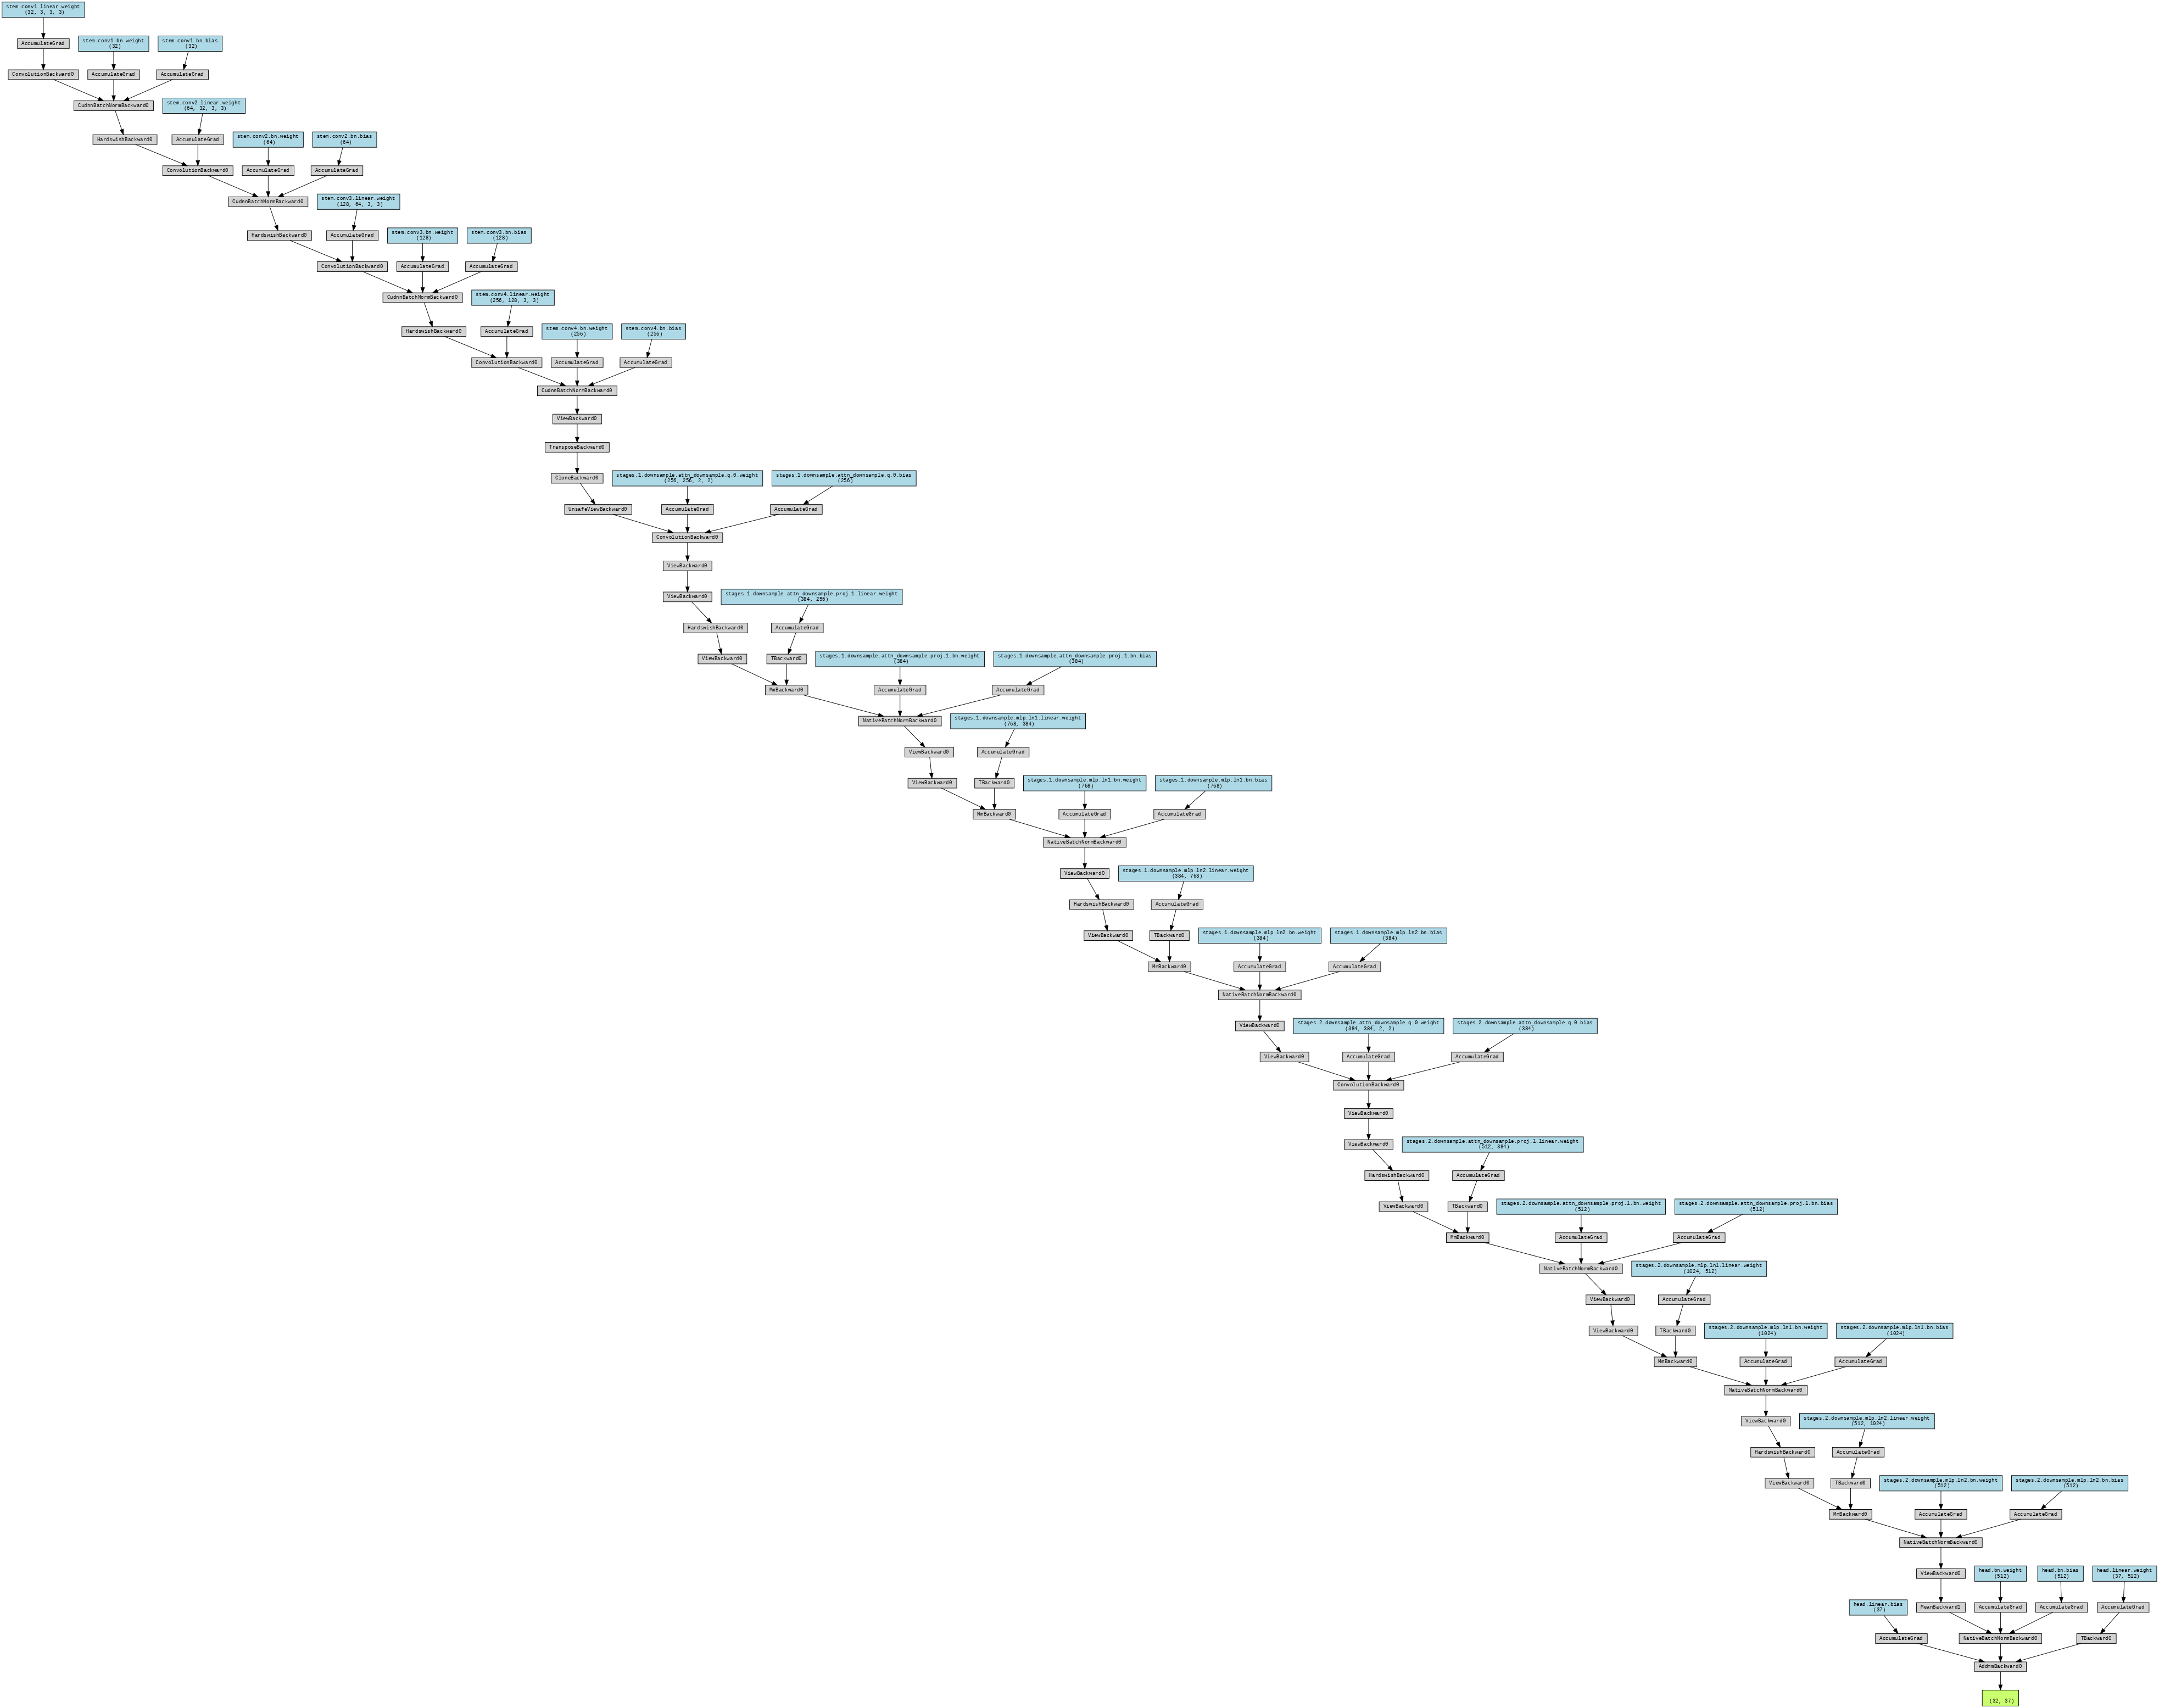

In [73]:
from torchviz import make_dot
from IPython.display import Image
model = GLALeViT().cuda()
input_tensor = torch.randn(32, 3, 224, 224).cuda()

output = model(input_tensor)
# Visualize the graph
make_dot(output, params=dict(model.named_parameters())).render("model_graph", format="png")
Image(filename="model_graph.png")

In [62]:
model = GLALeViT()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

batch_size = 32
learning_rate = 0.001
num_epochs = 50

In [ ]:
model.to(device)

GLALeViT(
  (stem): Stem16(
    (conv1): ConvNorm(
      (linear): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act1): Hardswish()
    (conv2): ConvNorm(
      (linear): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act2): Hardswish()
    (conv3): ConvNorm(
      (linear): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act3): Hardswish()
    (conv4): ConvNorm(
      (linear): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (stages): Sequential(
    (0):

In [ ]:
from torchinfo import summary
print(summary(model, input_size=(32, 3, 224, 224)))

Layer (type:depth-idx)                                  Output Shape              Param #
GLALeViT                                                [32, 37]                  --
├─Stem16: 1-1                                           [32, 256, 14, 14]         --
│    └─ConvNorm: 2-1                                    [32, 32, 112, 112]        --
│    │    └─Conv2d: 3-1                                 [32, 32, 112, 112]        864
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        64
│    └─Hardswish: 2-2                                   [32, 32, 112, 112]        --
│    └─ConvNorm: 2-3                                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-3                                 [32, 64, 56, 56]          18,432
│    │    └─BatchNorm2d: 3-4                            [32, 64, 56, 56]          128
│    └─Hardswish: 2-4                                   [32, 64, 56, 56]          --
│    └─ConvNorm: 2-5                                  

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
trainval_data = datasets.OxfordIIITPet(root="data", split="trainval", target_types="category", download=True, transform=transform)
test_data = datasets.OxfordIIITPet(root="data", split="test", target_types="category", download=True, transform=transform)
combined_data = ConcatDataset([trainval_data, test_data])

train_size = int(0.7 * len(combined_data))
val_size = int(0.15 * len(combined_data))
test_size = len(combined_data) - train_size - val_size
train_data, val_data, test_data = random_split(combined_data, [train_size, val_size, test_size])

In [ ]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

print(f"Train set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")

Train set size: 5144
Validation set size: 1102
Test set size: 1103


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        # Check if 'outputs' is a tuple and extract the logits if necessary
        if isinstance(outputs, tuple):
            outputs = outputs[0]  # Assuming the first element of the tuple contains the logits

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    accuracy = 100 * correct / total
    if torch.isnan(torch.tensor(epoch_loss)):
      print(f"Epoch {epoch+1}: NaN epoch loss detected!")
      print(f"running loss: {running_loss}, train_loader length: {len(train_loader)}")
    print(f"Epoch {epoch+1} Loss: {epoch_loss:.4f}")

In [ ]:
def evaluate(model, data_loader, criterion, device, phase="Validation"):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc=f"{phase}"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            # Check if 'outputs' is a tuple and extract the logits if necessary
            if isinstance(outputs, tuple):
                outputs = outputs[0]  # Assuming the first element of the tuple contains the logits

            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(data_loader)
    accuracy = 100 * correct / total
    print(f"{phase} Loss: {epoch_loss:.4f}, {phase} Accuracy: {accuracy:.2f}%")

In [ ]:
def measure_inference_time(model, data_loader, device):
    model.eval()
    times = []

    with torch.no_grad():
        for inputs, _ in data_loader:
            inputs = inputs.to(device)
            start_time = torch.cuda.Event(enable_timing=True)
            end_time = torch.cuda.Event(enable_timing=True)

            start_time.record()
            _ = model(inputs)  # inference 수행
            end_time.record()

            # 시간 측정
            torch.cuda.synchronize()  # CUDA에서 모든 커널이 완료될 때까지 대기
            elapsed_time = start_time.elapsed_time(end_time)  # 밀리초 단위로 반환
            times.append(elapsed_time)

    # 통계량 계산
    times_np = np.array(times)
    total_inferences = len(times_np)
    avg_time = np.mean(times_np)
    std_dev = np.std(times_np)
    max_time = np.max(times_np)
    min_time = np.min(times_np)

    # 결과 출력
    print(f"Inference Time Measurement Results:")
    print(f"Total Inferences: {total_inferences}")
    print(f"Average Time: {avg_time:.2f} ms")
    print(f"Standard Deviation: {std_dev:.2f} ms")
    print(f"Maximum Time: {max_time:.2f} ms")
    print(f"Minimum Time: {min_time:.2f} ms")

    return times

In [ ]:
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    train(model, train_loader, criterion, optimizer, device)
    evaluate(model, val_loader, criterion, device, phase="Validation")


Epoch 1/50


Training: 100%|██████████| 161/161 [00:34<00:00,  4.64it/s]


Epoch 1 Loss: 3.7267


Validation: 100%|██████████| 35/35 [00:05<00:00,  6.01it/s]


Validation Loss: 6.8265, Validation Accuracy: 3.09%

Epoch 2/50


Training: 100%|██████████| 161/161 [00:32<00:00,  4.94it/s]


Epoch 2 Loss: 3.7347


Validation: 100%|██████████| 35/35 [00:05<00:00,  6.04it/s]


Validation Loss: 3.7506, Validation Accuracy: 3.45%

Epoch 3/50


Training: 100%|██████████| 161/161 [00:32<00:00,  4.94it/s]


Epoch 3 Loss: 3.6687


Validation: 100%|██████████| 35/35 [00:05<00:00,  6.05it/s]


Validation Loss: 3.6105, Validation Accuracy: 3.18%

Epoch 4/50


Training: 100%|██████████| 161/161 [00:32<00:00,  4.96it/s]


Epoch 4 Loss: 3.5806


Validation: 100%|██████████| 35/35 [00:05<00:00,  6.24it/s]


Validation Loss: 3.7180, Validation Accuracy: 4.99%

Epoch 5/50


Training: 100%|██████████| 161/161 [00:32<00:00,  4.94it/s]


Epoch 5 Loss: 3.5432


Validation: 100%|██████████| 35/35 [00:05<00:00,  6.01it/s]


Validation Loss: 3.5448, Validation Accuracy: 6.53%

Epoch 6/50


Training: 100%|██████████| 161/161 [00:32<00:00,  4.96it/s]


Epoch 6 Loss: 3.5196


Validation: 100%|██████████| 35/35 [00:05<00:00,  5.92it/s]


Validation Loss: 3.6979, Validation Accuracy: 6.17%

Epoch 7/50


Training: 100%|██████████| 161/161 [00:32<00:00,  4.92it/s]


Epoch 7 Loss: 3.4972


Validation: 100%|██████████| 35/35 [00:05<00:00,  6.17it/s]


Validation Loss: 3.5417, Validation Accuracy: 6.44%

Epoch 8/50


Training: 100%|██████████| 161/161 [00:32<00:00,  4.95it/s]


Epoch 8 Loss: 3.4699


Validation: 100%|██████████| 35/35 [00:05<00:00,  6.23it/s]


Validation Loss: 3.5134, Validation Accuracy: 5.90%

Epoch 9/50


Training: 100%|██████████| 161/161 [00:32<00:00,  4.98it/s]


Epoch 9 Loss: 3.4471


Validation: 100%|██████████| 35/35 [00:05<00:00,  6.12it/s]


Validation Loss: 3.4101, Validation Accuracy: 6.90%

Epoch 10/50


Training: 100%|██████████| 161/161 [00:32<00:00,  4.96it/s]


Epoch 10 Loss: 3.4378


Validation: 100%|██████████| 35/35 [00:05<00:00,  6.21it/s]


Validation Loss: 4.1943, Validation Accuracy: 4.36%

Epoch 11/50


Training: 100%|██████████| 161/161 [00:32<00:00,  4.95it/s]


Epoch 11 Loss: 3.6360


Validation: 100%|██████████| 35/35 [00:05<00:00,  6.21it/s]


Validation Loss: 3.7137, Validation Accuracy: 3.09%

Epoch 12/50


Training: 100%|██████████| 161/161 [00:32<00:00,  4.98it/s]


Epoch 12 Loss: 3.6262


Validation: 100%|██████████| 35/35 [00:05<00:00,  6.12it/s]


Validation Loss: 3.6184, Validation Accuracy: 6.08%

Epoch 13/50


Training: 100%|██████████| 161/161 [00:32<00:00,  4.96it/s]


Epoch 13 Loss: 3.7002


Validation: 100%|██████████| 35/35 [00:05<00:00,  6.04it/s]


Validation Loss: 3.6330, Validation Accuracy: 3.36%

Epoch 14/50


Training: 100%|██████████| 161/161 [00:32<00:00,  4.94it/s]


Epoch 14 Loss: 3.5708


Validation: 100%|██████████| 35/35 [00:05<00:00,  6.11it/s]


Validation Loss: 3.6235, Validation Accuracy: 4.54%

Epoch 15/50


Training: 100%|██████████| 161/161 [00:32<00:00,  4.98it/s]


Epoch 15 Loss: 3.5192


Validation: 100%|██████████| 35/35 [00:05<00:00,  6.25it/s]


Validation Loss: 3.6268, Validation Accuracy: 4.63%

Epoch 16/50


Training: 100%|██████████| 161/161 [00:32<00:00,  4.92it/s]


Epoch 16 Loss: 3.5100


Validation: 100%|██████████| 35/35 [00:05<00:00,  6.07it/s]


Validation Loss: 3.5150, Validation Accuracy: 6.08%

Epoch 17/50


Training: 100%|██████████| 161/161 [00:32<00:00,  5.00it/s]


Epoch 17 Loss: 3.5111


Validation: 100%|██████████| 35/35 [00:05<00:00,  6.15it/s]


Validation Loss: 3.8572, Validation Accuracy: 4.26%

Epoch 18/50


Training: 100%|██████████| 161/161 [00:32<00:00,  4.96it/s]


Epoch 18 Loss: 3.5574


Validation: 100%|██████████| 35/35 [00:05<00:00,  6.21it/s]


Validation Loss: 3.5199, Validation Accuracy: 5.63%

Epoch 19/50


Training: 100%|██████████| 161/161 [00:32<00:00,  4.96it/s]


Epoch 19 Loss: 3.4854


Validation: 100%|██████████| 35/35 [00:05<00:00,  6.23it/s]


Validation Loss: 3.4731, Validation Accuracy: 6.08%

Epoch 20/50


Training: 100%|██████████| 161/161 [00:32<00:00,  4.99it/s]


Epoch 20 Loss: 3.4706


Validation: 100%|██████████| 35/35 [00:05<00:00,  6.14it/s]


Validation Loss: 3.4740, Validation Accuracy: 5.63%

Epoch 21/50


Training: 100%|██████████| 161/161 [00:32<00:00,  4.96it/s]


Epoch 21 Loss: 3.4568


Validation: 100%|██████████| 35/35 [00:05<00:00,  6.04it/s]


Validation Loss: 3.4512, Validation Accuracy: 6.08%

Epoch 22/50


Training: 100%|██████████| 161/161 [00:32<00:00,  4.92it/s]


Epoch 22 Loss: 3.4540


Validation: 100%|██████████| 35/35 [00:05<00:00,  6.15it/s]


Validation Loss: 3.4212, Validation Accuracy: 7.17%

Epoch 23/50


Training: 100%|██████████| 161/161 [00:32<00:00,  4.89it/s]


Epoch 23 Loss: 3.4444


Validation: 100%|██████████| 35/35 [00:05<00:00,  5.99it/s]


Validation Loss: 3.4432, Validation Accuracy: 7.35%

Epoch 24/50


Training: 100%|██████████| 161/161 [00:32<00:00,  4.92it/s]


Epoch 24 Loss: 3.4600


Validation: 100%|██████████| 35/35 [00:05<00:00,  5.93it/s]


Validation Loss: 3.4353, Validation Accuracy: 5.54%

Epoch 25/50


Training: 100%|██████████| 161/161 [00:32<00:00,  4.92it/s]


Epoch 25 Loss: 3.4257


Validation: 100%|██████████| 35/35 [00:05<00:00,  6.09it/s]


Validation Loss: 3.4328, Validation Accuracy: 6.90%

Epoch 26/50


Training: 100%|██████████| 161/161 [00:32<00:00,  4.92it/s]


Epoch 26 Loss: 3.4886


Validation: 100%|██████████| 35/35 [00:05<00:00,  6.06it/s]


Validation Loss: 3.4725, Validation Accuracy: 5.72%

Epoch 27/50


Training: 100%|██████████| 161/161 [00:32<00:00,  4.94it/s]


Epoch 27 Loss: 3.4618


Validation: 100%|██████████| 35/35 [00:05<00:00,  6.05it/s]


Validation Loss: 3.4721, Validation Accuracy: 6.99%

Epoch 28/50


Training: 100%|██████████| 161/161 [00:32<00:00,  4.90it/s]


Epoch 28 Loss: 3.4440


Validation: 100%|██████████| 35/35 [00:05<00:00,  6.11it/s]


Validation Loss: 4.4894, Validation Accuracy: 3.72%

Epoch 29/50


Training: 100%|██████████| 161/161 [00:32<00:00,  4.88it/s]


Epoch 29 Loss: 3.4564


Validation: 100%|██████████| 35/35 [00:05<00:00,  6.07it/s]


Validation Loss: 3.4240, Validation Accuracy: 6.08%

Epoch 30/50


Training: 100%|██████████| 161/161 [00:32<00:00,  4.90it/s]


Epoch 30 Loss: 3.4306


Validation: 100%|██████████| 35/35 [00:05<00:00,  5.90it/s]


Validation Loss: 3.4243, Validation Accuracy: 6.72%

Epoch 31/50


Training: 100%|██████████| 161/161 [00:32<00:00,  4.91it/s]


Epoch 31 Loss: 3.4369


Validation: 100%|██████████| 35/35 [00:05<00:00,  6.16it/s]


Validation Loss: 3.4104, Validation Accuracy: 7.08%

Epoch 32/50


Training: 100%|██████████| 161/161 [00:32<00:00,  4.91it/s]


Epoch 32 Loss: 3.4073


Validation: 100%|██████████| 35/35 [00:05<00:00,  6.06it/s]


Validation Loss: 3.4300, Validation Accuracy: 6.62%

Epoch 33/50


Training: 100%|██████████| 161/161 [00:32<00:00,  4.95it/s]


Epoch 33 Loss: 3.4700


Validation: 100%|██████████| 35/35 [00:05<00:00,  6.14it/s]


Validation Loss: 3.4475, Validation Accuracy: 5.26%

Epoch 34/50


Training: 100%|██████████| 161/161 [00:32<00:00,  4.96it/s]


Epoch 34 Loss: 3.4209


Validation: 100%|██████████| 35/35 [00:05<00:00,  6.12it/s]


Validation Loss: 3.4245, Validation Accuracy: 6.35%

Epoch 35/50


Training: 100%|██████████| 161/161 [00:32<00:00,  4.96it/s]


Epoch 35 Loss: 3.4535


Validation: 100%|██████████| 35/35 [00:05<00:00,  6.25it/s]


Validation Loss: 3.6410, Validation Accuracy: 5.08%

Epoch 36/50


Training: 100%|██████████| 161/161 [00:32<00:00,  4.96it/s]


Epoch 36 Loss: 3.4268


Validation: 100%|██████████| 35/35 [00:05<00:00,  6.15it/s]


Validation Loss: 3.4218, Validation Accuracy: 6.62%

Epoch 37/50


Training: 100%|██████████| 161/161 [00:32<00:00,  4.98it/s]


Epoch 37 Loss: 3.4387


Validation: 100%|██████████| 35/35 [00:05<00:00,  6.10it/s]


Validation Loss: 3.5363, Validation Accuracy: 5.81%

Epoch 38/50


Training: 100%|██████████| 161/161 [00:32<00:00,  4.97it/s]


Epoch 38 Loss: 3.4236


Validation: 100%|██████████| 35/35 [00:05<00:00,  6.11it/s]


Validation Loss: 3.4808, Validation Accuracy: 5.17%

Epoch 39/50


Training: 100%|██████████| 161/161 [00:32<00:00,  4.97it/s]


Epoch 39 Loss: 3.4145


Validation: 100%|██████████| 35/35 [00:05<00:00,  6.21it/s]


Validation Loss: 3.4252, Validation Accuracy: 6.35%

Epoch 40/50


Training: 100%|██████████| 161/161 [00:32<00:00,  4.96it/s]


Epoch 40 Loss: 3.4054


Validation: 100%|██████████| 35/35 [00:05<00:00,  6.07it/s]


Validation Loss: 3.4201, Validation Accuracy: 6.26%

Epoch 41/50


Training: 100%|██████████| 161/161 [00:32<00:00,  4.95it/s]


Epoch 41 Loss: 3.3739


Validation: 100%|██████████| 35/35 [00:05<00:00,  6.18it/s]


Validation Loss: 3.4101, Validation Accuracy: 7.62%

Epoch 42/50


Training: 100%|██████████| 161/161 [00:32<00:00,  4.96it/s]


Epoch 42 Loss: 3.3777


Validation: 100%|██████████| 35/35 [00:05<00:00,  6.25it/s]


Validation Loss: 3.4271, Validation Accuracy: 6.62%

Epoch 43/50


Training: 100%|██████████| 161/161 [00:32<00:00,  4.94it/s]


Epoch 43 Loss: 3.3619


Validation: 100%|██████████| 35/35 [00:05<00:00,  6.12it/s]


Validation Loss: 3.4820, Validation Accuracy: 4.54%

Epoch 44/50


Training: 100%|██████████| 161/161 [00:32<00:00,  4.97it/s]


Epoch 44 Loss: 3.3688


Validation: 100%|██████████| 35/35 [00:05<00:00,  5.96it/s]


Validation Loss: 3.3993, Validation Accuracy: 7.26%

Epoch 45/50


Training: 100%|██████████| 161/161 [00:32<00:00,  4.94it/s]


Epoch 45 Loss: 3.3566


Validation: 100%|██████████| 35/35 [00:05<00:00,  6.22it/s]


Validation Loss: 3.3915, Validation Accuracy: 7.26%

Epoch 46/50


Training: 100%|██████████| 161/161 [00:32<00:00,  4.95it/s]


Epoch 46 Loss: 3.3558


Validation: 100%|██████████| 35/35 [00:05<00:00,  6.13it/s]


Validation Loss: 3.4086, Validation Accuracy: 6.62%

Epoch 47/50


Training: 100%|██████████| 161/161 [00:32<00:00,  4.96it/s]


Epoch 47 Loss: 3.3754


Validation: 100%|██████████| 35/35 [00:05<00:00,  6.13it/s]


Validation Loss: 3.6231, Validation Accuracy: 7.71%

Epoch 48/50


Training: 100%|██████████| 161/161 [00:32<00:00,  4.97it/s]


Epoch 48 Loss: 3.3476


Validation: 100%|██████████| 35/35 [00:05<00:00,  6.13it/s]


Validation Loss: 3.4023, Validation Accuracy: 7.99%

Epoch 49/50


Training: 100%|██████████| 161/161 [00:32<00:00,  4.97it/s]


Epoch 49 Loss: 3.3297


Validation: 100%|██████████| 35/35 [00:05<00:00,  6.04it/s]


Validation Loss: 3.4328, Validation Accuracy: 6.99%

Epoch 50/50


Training: 100%|██████████| 161/161 [00:32<00:00,  4.97it/s]


Epoch 50 Loss: 3.3228


Validation: 100%|██████████| 35/35 [00:05<00:00,  6.18it/s]

Validation Loss: 3.3867, Validation Accuracy: 8.98%


In [ ]:
print("\nFinal Test Evaluation")
evaluate(model, test_loader, criterion, device, phase="Test")


Final Test Evaluation


Test: 100%|██████████| 35/35 [00:05<00:00,  6.29it/s]

Test Loss: 3.3853, Test Accuracy: 7.80%


In [ ]:
times = measure_inference_time(model, test_loader, device)

Inference Time Measurement Results:
Total Inferences: 35
Average Time: 14.04 ms
Standard Deviation: 0.38 ms
Maximum Time: 15.50 ms
Minimum Time: 13.40 ms
